In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import math

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5
plt.rcParams["font.size"] = 7

width=0.6

In [2]:
# https://stackoverflow.com/questions/10481990/matplotlib-axis-with-two-scales-shared-origin

def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

In [3]:
def aSum(lists):
    return [sum([l[ind] for l in lists]) for ind in range(len(lists[0]))]

In [4]:
def styleAx(ax, ax2, ytop, xleft, xright):
    ### set lim ###
    lo, hi = ax.get_ylim()
    if ytop is not None:
        hi = ytop
    left_lo = - hi * 0.2
    ax.set_ylim(left_lo, hi)
    
    ax2.set_ylim(-0.2, 1)
    
    ax.set_xlim(xleft, xright)
    ### set lim ###
    
    ### spine color ###
    ax2.spines['right'].set_color('red')
    ax2.tick_params(axis='y', colors='red')
    ### spine color ###
    
    ### control spines ###
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    
    ### control spines ###
    
    ax.set_yticks([x for x in ax.get_yticks() if x >=0 and x < hi])
    ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax2.set_yticklabels(['0', '20', '40', '60', '80', '100'])
    
    align_yaxis(ax, 0, ax2, 0)
    ax2.spines['right'].set_bounds(0, 1)
    ax.spines['left'].set_bounds(0, hi)
    
    return left_lo

In [5]:
def plotEditor(ID, ax, msg='', ytop=None):
    ax2 = ax.twinx()   
    
    colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072']
    
    bad_papers = papers[papers.NewAuthorId == ID]
    bad_count = bad_papers.groupby(['Year','issn','during','edit']).PaperId.nunique().reset_index()
    
    x= [year for year in range(bad_count.Year.min(), bad_count.Year.max()+1)]
    issn = list(bad_count.issn.unique())
    journals = [[] for i in issn]
    notj = []
    notedit = []
    
    print(issn)
    if len(issn) == 1:
        issnlabel=["Editor's journal"]
    elif len(issn) == 2:
        issnlabel=["Editor's $1^{st}$ journal","Editor's $2^{nd}$ journal"]
    elif len(issn) == 3:
        issnlabel=["Editor's $1^{st}$ journal","Editor's $2^{nd}$ journal",
                  "Editor's $3^{rd}$ journal"]
    elif len(issn) == 4:
        issnlabel=["Editor's $1^{st}$ journal","Editor's $2^{nd}$ journal",
                   "Editor's $3^{rd}$ journal","Editor's $4^{th}$ journal"]
    else:
        print("ERROR!")

    for year in range(bad_count.Year.min(), min(bad_count.Year.max()+1, 2019)):
        for ind, j in enumerate(issn):
            
            df = bad_count[(bad_count.issn == j) &
                           (bad_count.Year == year) &
                           (bad_count.during == True) &
                           (bad_count.edit == True)
                          ]
            journals[ind].append(df.PaperId.sum())
        
        df = bad_count[(bad_count.Year == year) & (bad_count.during == False) & (bad_count.edit == True)]
        notj.append(df.PaperId.sum())
        
        df = bad_count[(bad_count.Year == year) & (bad_count.edit == False)]
        notedit.append(df.PaperId.sum())
        
    assert(bad_papers.shape[0] == bad_count.PaperId.sum())
    assert(bad_papers.shape[0] == sum(aSum(journals)) + sum(notj) + sum(notedit))
        
    ax.bar(x, journals[0], width, label=issnlabel[0], color=colors[0])
    for i in range(1, len(journals)):
        ax.bar(x, journals[i], width, label=issnlabel[i], color=colors[i], bottom=aSum(journals[:i]))
        
    if sum(notj) != 0:
        ax.bar(x, notj, width, bottom=aSum(journals), color='black',
               label="Editor's journal but\nnot during editorship" )
    if sum(notedit) != 0:
        ax.bar(x, notedit, width, bottom=aSum([aSum(journals), notj]), color='grey', label='Other journals')
    
    if ID != 78626657:
        ax.legend()
    
    left_lo = styleAx(ax, ax2, ytop, bad_count.Year.min()-0.5, bad_count.Year.max()+0.5)
    multiplier = 0.55
    
    for ind, j in enumerate(issn):
        row = editors[(editors.NewAuthorId == ID) & (editors.issn == j)]
        left, right = int(row.start_year), int(row.end_year)
        ax.hlines(multiplier * left_lo, left, right, color=colors[ind], linewidths=1)
        
        multiplier += 0.1
        
    steps = []
    running_sum, inj = 0, 0
    most = 0
    for i in range(len(x)):
        running_sum += aSum(journals)[i] + notj[i] + notedit[i]
        inj += aSum(journals)[i]
        steps.append(inj/running_sum)
        most = max(most, inj/running_sum)
    print("highest percentage:", most)
    
    ax2.step([i+1 for i in x], steps, color='red', lw=0.5)
    
    ax.set_ylabel('Paper count')
    if msg == '2nd':
        ax2.set_ylabel("Percentage of papers published in the editor's journal out of all papers authored by the editor to date",c='red')

In [6]:
width=0.6

def plotJournal(issn, ax, ytop, middle=False):
    ax2 = ax.twinx()   
    
    total = total_papers[total_papers.issn == issn]
    editor = editor_papers[editor_papers.issn == issn]
    
    running_b, running_t = 0, 0
    steps=[]
    
    MAX =  min(total.Year.max()+1, 2019)
    
    for year in range(total.Year.min(), MAX):
        bottom = editor[editor.Year == year].Count.values
        if len(bottom) != 0: bottom = bottom[0]
        else: bottom=0
            
        top = total[total.Year == year].Total.values
        if len(top) != 0: top = top[0]
        else: top=0
        
        ax.bar(year, bottom, width, color='#5ac0c0', label='Paper authored by editor(s) of the journal')
        ax.bar(year, top-bottom, width, color='gray', bottom=bottom, label='Paper authored by other scientists')
        
        running_b += bottom
        running_t += top
        steps.append(running_b/running_t if top!=0 else 0)
        
    ax.legend(handles=[Patch(facecolor='#5ac0c0', label='Paper authored by editor(s) of the journal'),
                      Patch(facecolor='gray', label='Paper authored by other scientists')],
             loc='upper left')
    
    if issn == '14670895' or issn == '01678116':
        ax.set_xticks([x for x in range(math.ceil(total.Year.min()/5)*5, math.floor((MAX-1)/5)*5 + 1, 5)])
        print([x for x in range(math.ceil(total.Year.min()/5)*5, math.floor((MAX-1)/5)*5, 5)])
        
    ax2.step([year for year in range(total.Year.min(), MAX)], steps, color='red', lw=0.5)
    
    styleAx(ax, ax2, ytop, total.Year.min()-0.5, MAX-0.5)
    
    if middle:
        ax2.set_ylabel("Percentage of papers authored by the journal's editor(s) out of all papers published in the journal to date", c='red')
        
    ax.set_ylabel('Paper count')

In [7]:
# left columns
papers = pd.read_csv('../data/figure_3/EditorPapers.csv',sep='\t',
                     dtype={'Year':int,'edit':bool,'during':bool,'EditorId':int,'IssnId':int,'AnoPaperId':int})
papers = papers.rename(columns={'EditorId':'NewAuthorId', 'IssnId':'issn', 'AnoPaperId':'PaperId'})

editors = pd.read_csv('../data/figure_3/Editors.csv',sep='\t',
                      dtype={'start_year':int,'end_year':int,'EditorId':int,'IssnId':int})
editors = editors.rename(columns={'EditorId':'NewAuthorId','IssnId':'issn'})

In [8]:
# right columns
editor_papers = pd.read_csv('../data/figure_3/EditorPapersInJournal.csv', sep='\t',
                           dtype={"IssnId":int,"Year":int,"Count":int})
editor_papers = editor_papers.rename(columns={'IssnId':'issn'})

total_papers = pd.read_csv('../data/figure_3/TotalPapersInJournal.csv', sep='\t',
                         dtype={"IssnId":int,"Year":int,"Count":int})
total_papers = total_papers.rename(columns={'IssnId':'issn'})

editor_papers.shape, total_papers.shape

((56, 3), (62, 3))

[1581]
highest percentage: 0.7352941176470589
[4]
highest percentage: 0.7205882352941176
[5339, 89, 197, 564]
highest percentage: 0.8521739130434782


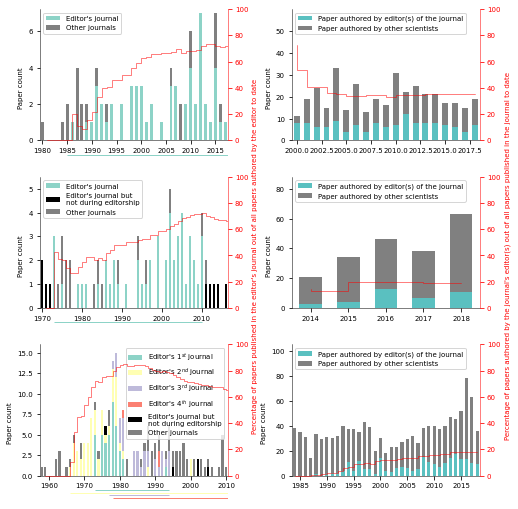

In [9]:
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(18.3*cm, 18*cm))
plt.rcParams.update({'font.size': 7})

ax = plt.subplot(3, 2, 1)
plotEditor(12054, ax, '1st', 7.2)

ax = plt.subplot(3, 2, 3)
plotEditor(15203, ax, '2nd', 5.5)

ax = plt.subplot(3, 2, 5)
plotEditor(13531, ax, '3rd', 16)

ax = plt.subplot(3, 2, 2)
plotJournal(326, ax, 60)

ax = plt.subplot(3, 2, 4)
plotJournal(1366, ax, 88, True)

ax = plt.subplot(3, 2, 6)
plotJournal(6, ax, 105)

plt.tight_layout()

plt.savefig('../figures/fig_3.pdf', bbox_inches = 'tight', pad_inches = 0)